In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import gc
from keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping
from VGG16.vgg16 import CreateModelLocal,FitModel
from VGG16.PrepareData import PrepareData
from VGG16.CheckPatientDVH import checkdvh
import matplotlib.pyplot as plt
from random import sample
from keras import optimizers
import keras.backend as K
from keras.callbacks import History 
from VGG16.Evaluate import Evaluate
from keras.backend.tensorflow_backend import set_session
from keras_tqdm import TQDMNotebookCallback


#Esto tenemos que hacerlo por que la gpu (RTX 2060) no es capaz de asignar memoria dinamicamente. 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  
config.log_device_placement = True                                  
set_session(sess)  # set TensorFlow sesion por defecto

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Using TensorFlow backend.


In [2]:
# Carga de datos
Data = np.load('Data/Datos-Prostata-SIB.npy')

In [3]:
X = Data[0] # Estructuras cada entrada es NcortesCTx226x226x3
y1= Data[1] # DVH recto, cada entrada es 1x20
y2 = Data[2] # DVH vejiga, cada entrada es 1x20
XCT = Data[3]
y = [None]*len(y1)   # Serán entradas de 1x40
for i in range(len(y1)):
    y[i] = np.concatenate((y1[i],y2[i]),axis=1)

NHC = Data[4] #ID paciente
 
print('Número de pacientes:' + str(len(NHC)))

# Codificar los pacientes
ExcelNHC = pd.read_excel('ExcelNHC.xlsx',index_col=1)
for i,v in enumerate(NHC):
    if v[0:4]=='0000':
        NHC[i] =str(ExcelNHC.loc[float(v[4:])][0])
Rundir="Prostate"
logPath = os.path.join("Graph",Rundir)

Número de pacientes:120


In [4]:
from keras import regularizers
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Dropout
from keras.applications.vgg16 import VGG16

def CreateModelLocal(input_shape1,input_shape2,channels,output,L,Verbose= 0,dropout=0,FineTunning=False):
    
# Entrada de la red y modelo elegido    
    input = Input(shape=(input_shape1,input_shape2,channels),name = 'image_input')
    base_model = VGG16(weights='imagenet', include_top=False,pooling='avg')
    
    for layer in base_model.layers:
            layer.trainable = FineTunning # Cambiar a True si se necesita, por defecto False
            
# Salida de la red preentrenada           
    output_vgg16_conv = base_model(input)
    
# Creación de la fully connected    
    x = Dense(1000,  name='capa_entrada', kernel_initializer = 'glorot_uniform',activation='relu',
              activity_regularizer=regularizers.l2(L))(output_vgg16_conv)
    if dropout!=0:
       x = Dropout(dropout)(x)
    x = Dense(1000,  name='capa2', kernel_initializer = 'glorot_uniform',activation='relu')(x)
    if dropout!=0:
       x = Dropout(dropout)(x)
    x = Dense(300,  name='capa3', kernel_initializer = 'glorot_uniform',activation='relu')(x)
    x = Dense(100,  name='capa4', kernel_initializer = 'glorot_uniform',activation='relu')(x)
    x = Dense(output,  name='capa_salida', kernel_initializer = 'glorot_uniform')(x)
    model = Model(inputs=input, outputs=x)
    
    if Verbose ==1:    
        
        model.summary()

    return model

In [5]:
# Callbacks  para el modelo
checkpointcallback = ModelCheckpoint(os.path.join(logPath,'BestModel'),
                monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=True, mode='auto', period=1)

    
Early = EarlyStopping(monitor='val_loss', min_delta=1.0, patience=15, verbose=0, mode='auto', baseline=None)


In [6]:
# Formato de los parámetros de entrada
input_shape=226
channels=3
# Parámetros de la red
nepoch= 100
batch_size = 2000
Verbose=1
L=0
NHCAnalized=[]
Cost=[]
bucle= 1
NHC = list(NHC)

# Fijamos unos pacientes de test de manera aleatoria
Test=['8','17','28','36','45','73','82','115','123','125']
TestInt=[]
for i in Test:
    TestInt.append(NHC.index(i))
X_train,X_val,X_test,y_train,y_test,y_val,NHC_train,NHC_test,NHC_val,PatientTest= PrepareData(X,y,NHC,[],[],TestInt)

# Datos de entrada concatenados
X_trainC =np.concatenate((X_train))
X_valC = np.concatenate((X_val))

# Datos de salida concatenados
y_trainC =np.concatenate((y_train))
y_valC = np.concatenate((y_val))

# Creación  y compilación del modelo
model =  CreateModelLocal(input_shape,input_shape,channels,y[0].shape[1],L,Verbose)
model.compile(optimizer = 'adam', loss ='mae', metrics = ["mae",'mse'])

Suboptimos NHC Excluidos: 
[]
Suboptimos Excluidos: 
[]
Candidatos a Test : 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
Pacientes excluidos al Test : 
[]
Elegidos para Test : 
[99, 35, 47, 56, 65, 92, 102, 14, 22, 24]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 226, 226, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 512)               14714688  
____

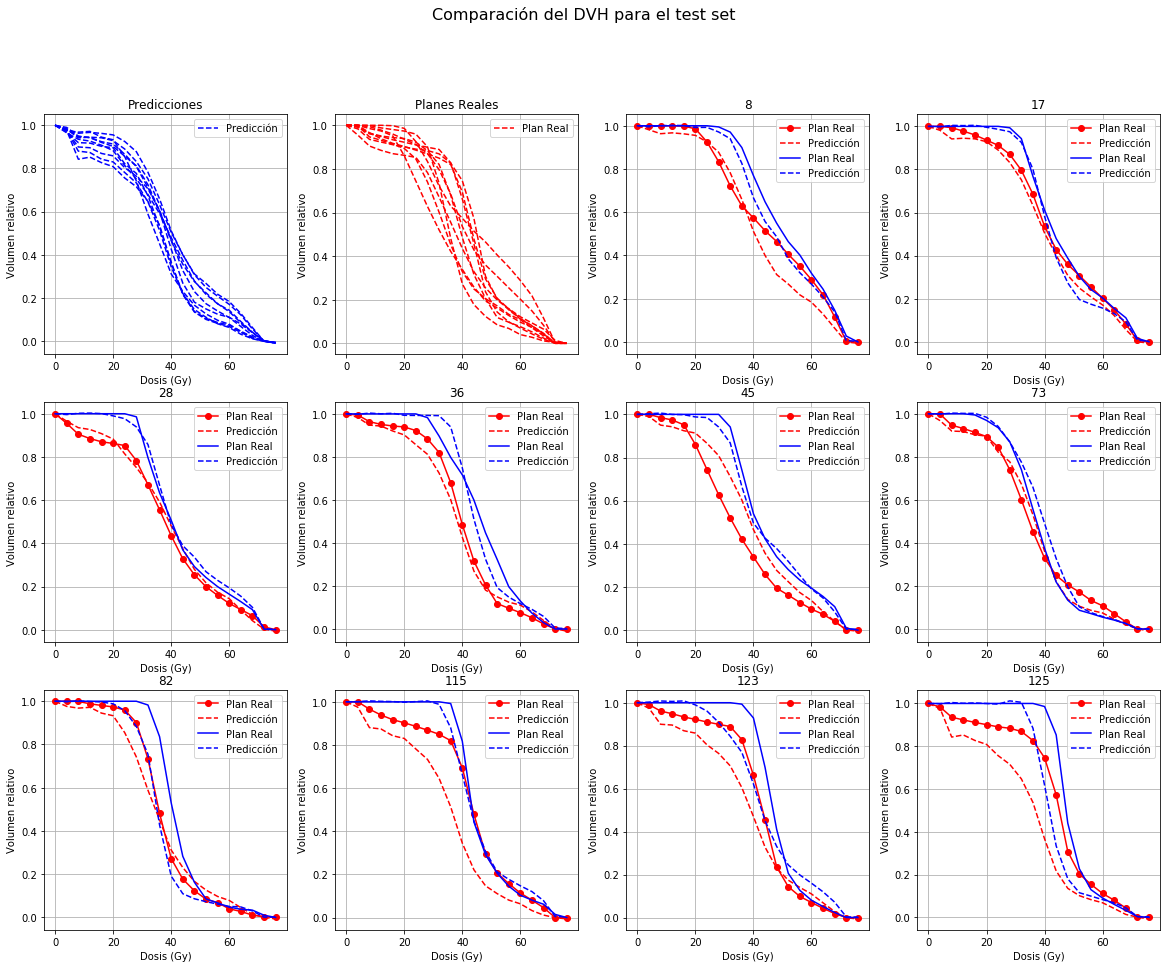

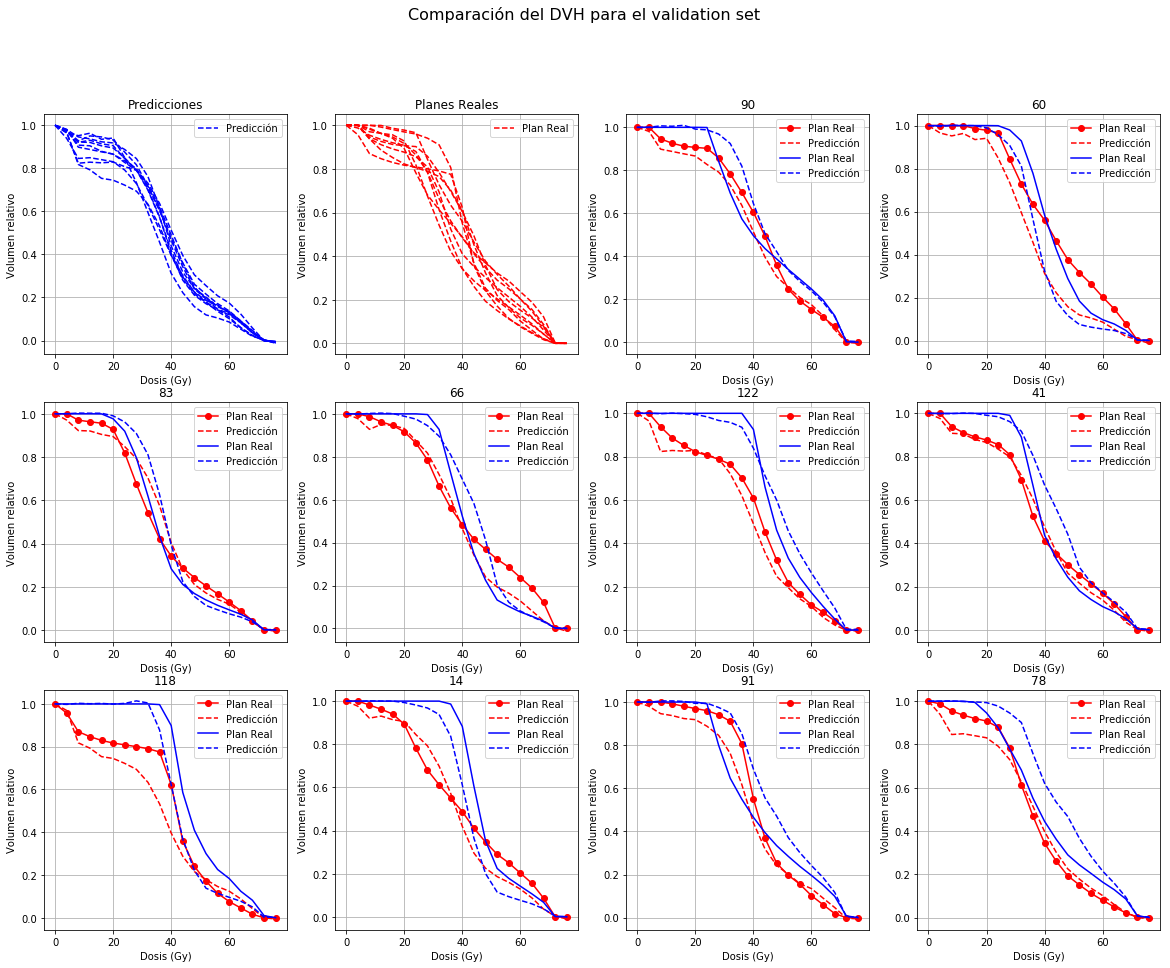

In [7]:
# Entrenamiendo de la red
History = model.fit(X_trainC,y_trainC,batch_size=20,validation_data=[X_valC,y_valC],epochs=100,shuffle=True,
                    verbose= 0, callbacks = [TQDMNotebookCallback()])

# Evaluación del test y validación
c,c2= Evaluate(X_test,y_test,NHC_test,model,'test',1)  

c,c2= Evaluate(X_val,y_val,NHC_val,model,'validation',1)  


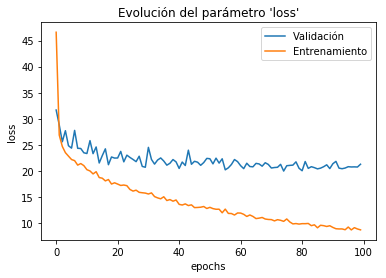

Valor mínimo del parámetro 'loss' para el conjunto de validación: 19.933947679807815


In [9]:
# Se visualiza la evolución del parámetro "loss" en el conjunto de entrenamiento y de validación
# en función de las épocas. 
def plot_loss(History):
    val_loss = History.history['val_loss']
    training_loss = History.history['loss']
    # Gráfico
    plt.plot(val_loss,label="Validación")
    plt.plot(training_loss,label="Entrenamiento")
    plt.title("Evolución del parámetro 'loss'")  
    plt.xlabel("epochs")   
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    
plot_loss(History)
print("Valor mínimo del parámetro 'loss' para el conjunto de validación: " + 
      str(np.min(History.history['val_loss'])))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 226, 226, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
capa_entrada (Dense)         (None, 1000)              513000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
capa2 (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
capa3 (Dense)                (None, 300)               300300    
__________

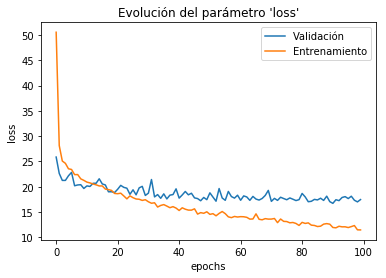

Valor mínimo del parámetro 'loss' para el conjunto de validación: 16.701303764987173
Training Dropout = 0.2


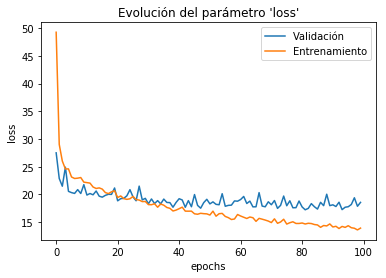

Valor mínimo del parámetro 'loss' para el conjunto de validación: 17.240550638769594
Training Dropout = 0.5


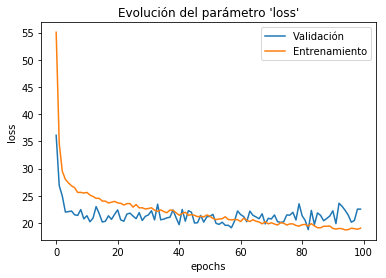

Valor mínimo del parámetro 'loss' para el conjunto de validación: 18.76810915329877
Training Dropout = 0.8


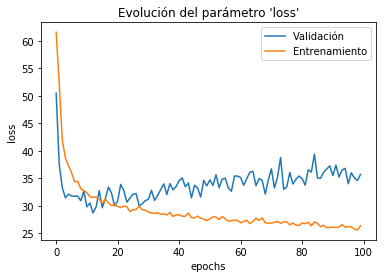

Valor mínimo del parámetro 'loss' para el conjunto de validación: 28.72952267580935


In [12]:
# Modelo con Dropout
D= [0.1,0.2,0.5,0.8]  #probamos varios valores de dropout
L = 0 # sin regularización
Finetunning = False  # sin fine tunning
Verbose = 1

for i in D:
    model =  CreateModelLocal(input_shape,input_shape,channels,y[0].shape[1],L,Verbose,i,Finetunning)
    model.compile(optimizer = 'adam', loss ='mae', metrics = ["mae",'mse'])
    print("Training Dropout = " + str(i) )
    History = model.fit(X_trainC,y_trainC,batch_size=32,validation_data=[X_valC,y_valC],epochs=100,shuffle=True,
                        verbose=0,callbacks = [TQDMNotebookCallback()])
    plot_loss(History)
    print("Valor mínimo del parámetro 'loss' para el conjunto de validación: " + 
      str(np.min(History.history['val_loss'])))
    Verbose = 0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 226, 226, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
capa_entrada (Dense)         (None, 1000)              513000    
_________________________________________________________________
capa2 (Dense)                (None, 1000)              1001000   
_________________________________________________________________
capa3 (Dense)                (None, 300)               300300    
_________________________________________________________________
capa4 (Dense)                (None, 100)               30100     
_________________________________________________________________
capa_salida (Dense)          (None, 40)                4040      
Total para

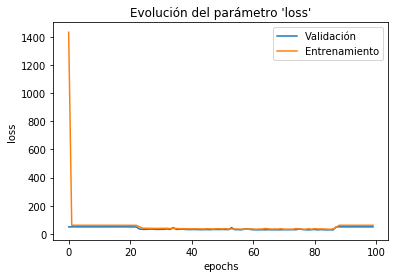

Valor mínimo del parámetro 'loss' para el conjunto de validación: 28.766835312709173
Training Regularization = 0.2


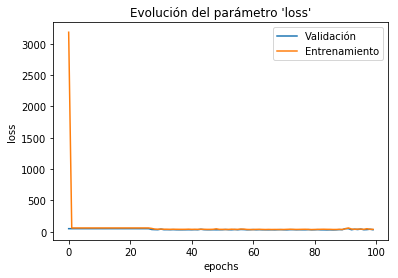

Valor mínimo del parámetro 'loss' para el conjunto de validación: 30.57506461765455
Training Regularization = 0.5


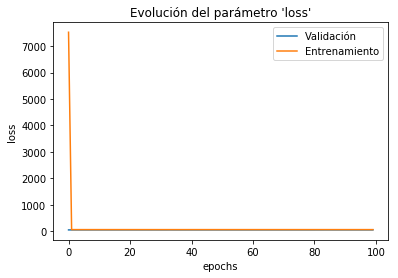

Valor mínimo del parámetro 'loss' para el conjunto de validación: 50.086559827370415
Training Regularization = 0.8


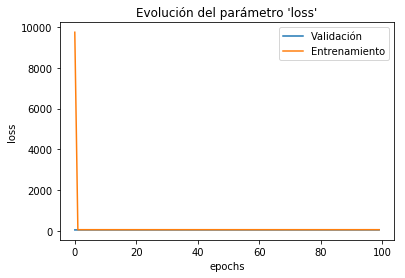

Valor mínimo del parámetro 'loss' para el conjunto de validación: 50.33811705801493


In [13]:
# Modelo con Regularización
L= [0.1,0.2,0.5,0.8] # probamos varios valores de regularización
d=0  # sin dropout
Finetunning = False  # sin fine tunning
Verbose = 1
for i in L:
    model =  CreateModelLocal(input_shape,input_shape,channels,y[0].shape[1],i,Verbose,d,Finetunning)
    model.compile(optimizer = 'adam', loss ='mae', metrics = ["mae",'mse'])
    print("Training Regularization = " + str(i) )

    History = model.fit(X_trainC,y_trainC,batch_size=32,validation_data=[X_valC,y_valC],epochs=nepoch,shuffle=True,
                        verbose=0,callbacks = [TQDMNotebookCallback()])
    plot_loss(History)
    print("Valor mínimo del parámetro 'loss' para el conjunto de validación: " + 
          str(np.min(History.history['val_loss'])))
    Verbose = 0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 226, 226, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
capa_entrada (Dense)         (None, 1000)              513000    
_________________________________________________________________
capa2 (Dense)                (None, 1000)              1001000   
_________________________________________________________________
capa3 (Dense)                (None, 300)               300300    
_________________________________________________________________
capa4 (Dense)                (None, 100)               30100     
_________________________________________________________________
capa_salida (Dense)          (None, 40)                4040      
Total para

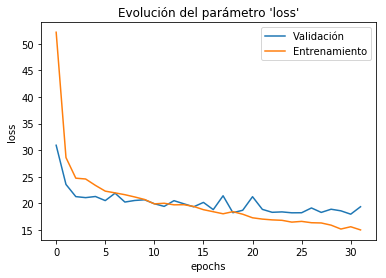

Valor mínimo del parámetro 'loss' para el conjunto de validación: 17.945748995027273


In [14]:
# Modelo con Early Stopping
checkpointcallback = ModelCheckpoint(os.path.join(logPath,'BestModel'),
                monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=True, mode='auto', period=1)

    
Early = EarlyStopping(monitor='val_loss', min_delta=1.0, patience=15, verbose=0, mode='auto', baseline=None)

L=0 # sin regularización
d= 0 # sin dropout
Finetunning = False  # sin fine tunning

model =  CreateModelLocal(input_shape,input_shape,channels,y[0].shape[1],L,1,d,Finetunning)
model.compile(optimizer = 'adam', loss ='mae', metrics = ["mae",'mse'])

History = model.fit(X_trainC,y_trainC,batch_size=32,validation_data=[X_valC,y_valC],epochs=nepoch,shuffle=True,
                    verbose=0,callbacks=[checkpointcallback,Early,TQDMNotebookCallback()])
plot_loss(History)
print("Valor mínimo del parámetro 'loss' para el conjunto de validación: " + 
      str(np.min(History.history['val_loss'])))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 226, 226, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
capa_entrada (Dense)         (None, 1000)              513000    
_________________________________________________________________
capa2 (Dense)                (None, 1000)              1001000   
_________________________________________________________________
capa3 (Dense)                (None, 300)               300300    
_________________________________________________________________
capa4 (Dense)                (None, 100)               30100     
_________________________________________________________________
capa_salida (Dense)          (None, 40)                4040      
Total para

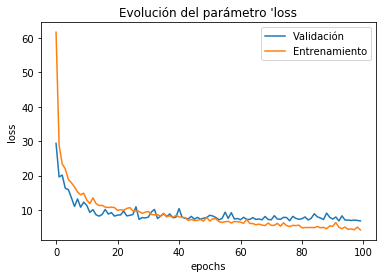

Valor mínimo del parámetro 'loss' para el conjunto de validación: 6.8297693841056715


In [9]:
# Entrenamiento del modelo con Fine Tunning
L=0  # sin regularización
d= 0 #sin dropout 
nepoch = 100
model =  CreateModelLocal(input_shape,input_shape,channels,y[0].shape[1],L,1,d,True)
model.compile(optimizer = 'adam', loss ='mae', metrics = ["mae",'mse'])

print("Entrenando modelo con Fine Tunning")
History = model.fit(X_trainC,y_trainC,batch_size=32,validation_data=[X_valC,y_valC],epochs=nepoch,shuffle=True,
                    verbose=0,callbacks = [TQDMNotebookCallback()])
plot_loss(History)
print("Valor mínimo del parámetro 'loss' para el conjunto de validación: " + 
      str(np.min(History.history['val_loss'])))

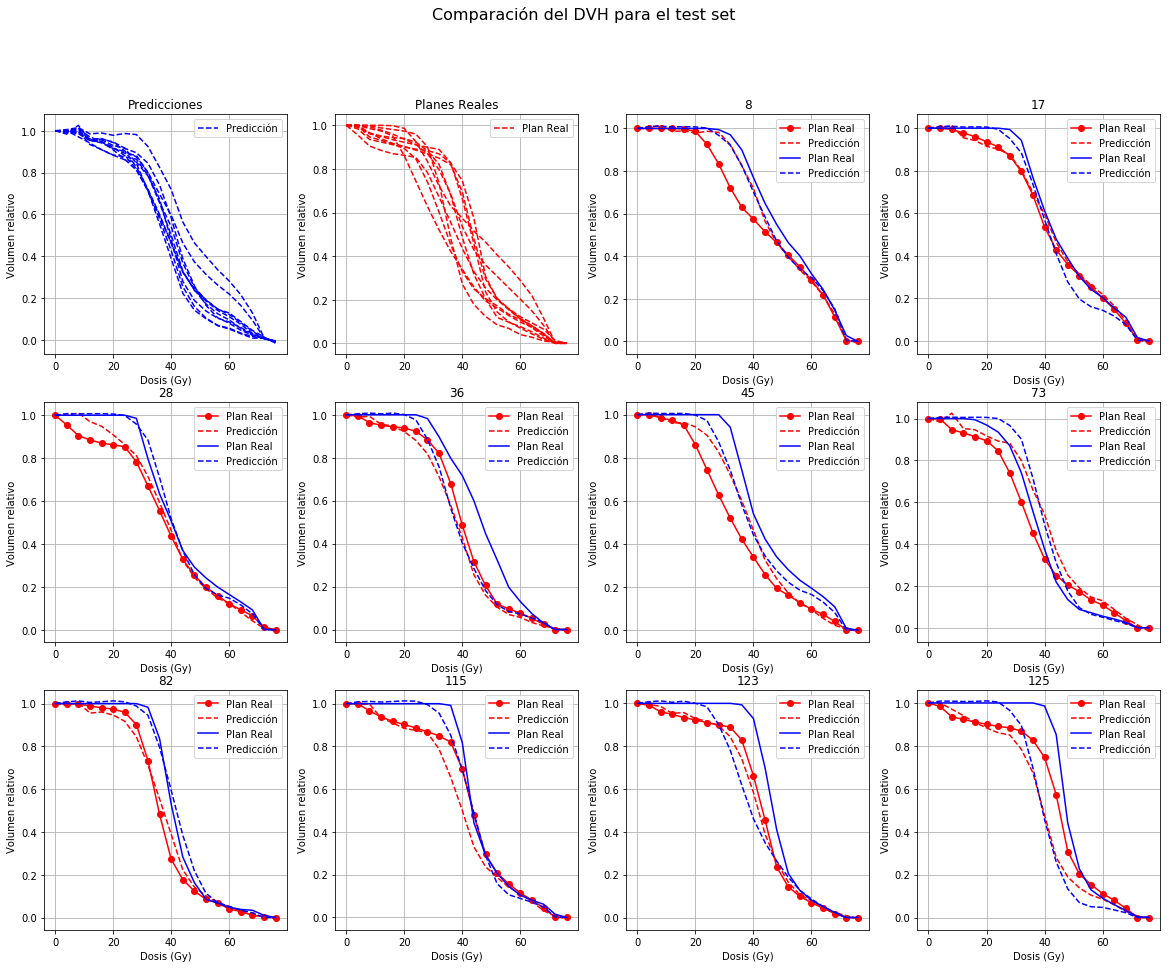

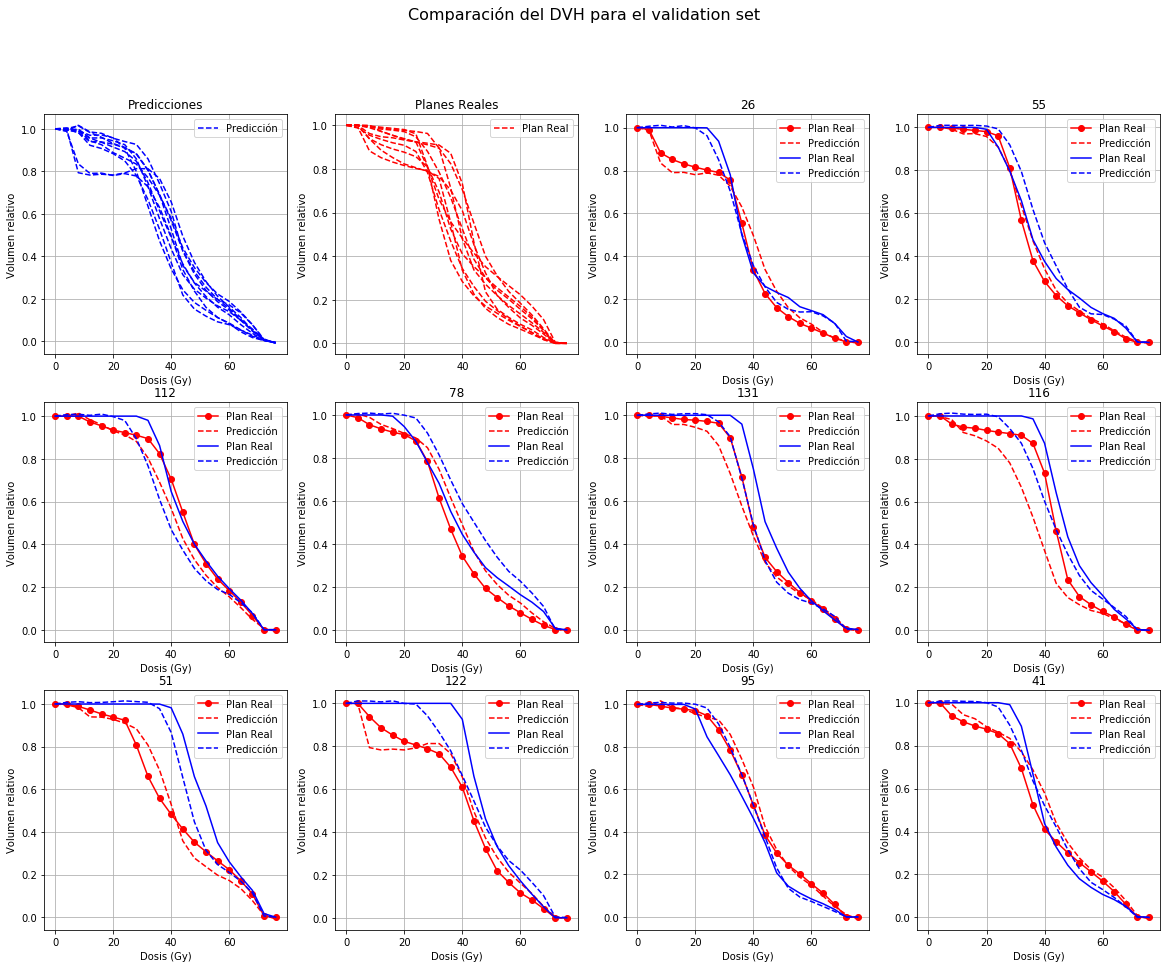

In [19]:
# Evaluación del test y validación
c,c2= Evaluate(X_test,y_test,NHC_test,model,'test',1)  

c,c2= Evaluate(X_val,y_val,NHC_val,model,'validation',1)  